[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/luleu96/GenAIinDD_Exercises/blob/work/Exercises/Exercise_3/Importance_Sampling.ipynb)

Source: [MCMC: A Beginnner's Guide](https://github.com/prappleizer/prappleizer.github.io/blob/master/Tutorials/MCMC/MCMC_Tutorial_Solution.ipynb)

In [1]:
!pip install emcee
!pip install corner

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)

In [3]:
# load ice dataset: temperature deviation of the earth against its age
ice_data = np.loadtxt('/content/ice_core_data.txt')
ice_data = np.transpose(ice_data)

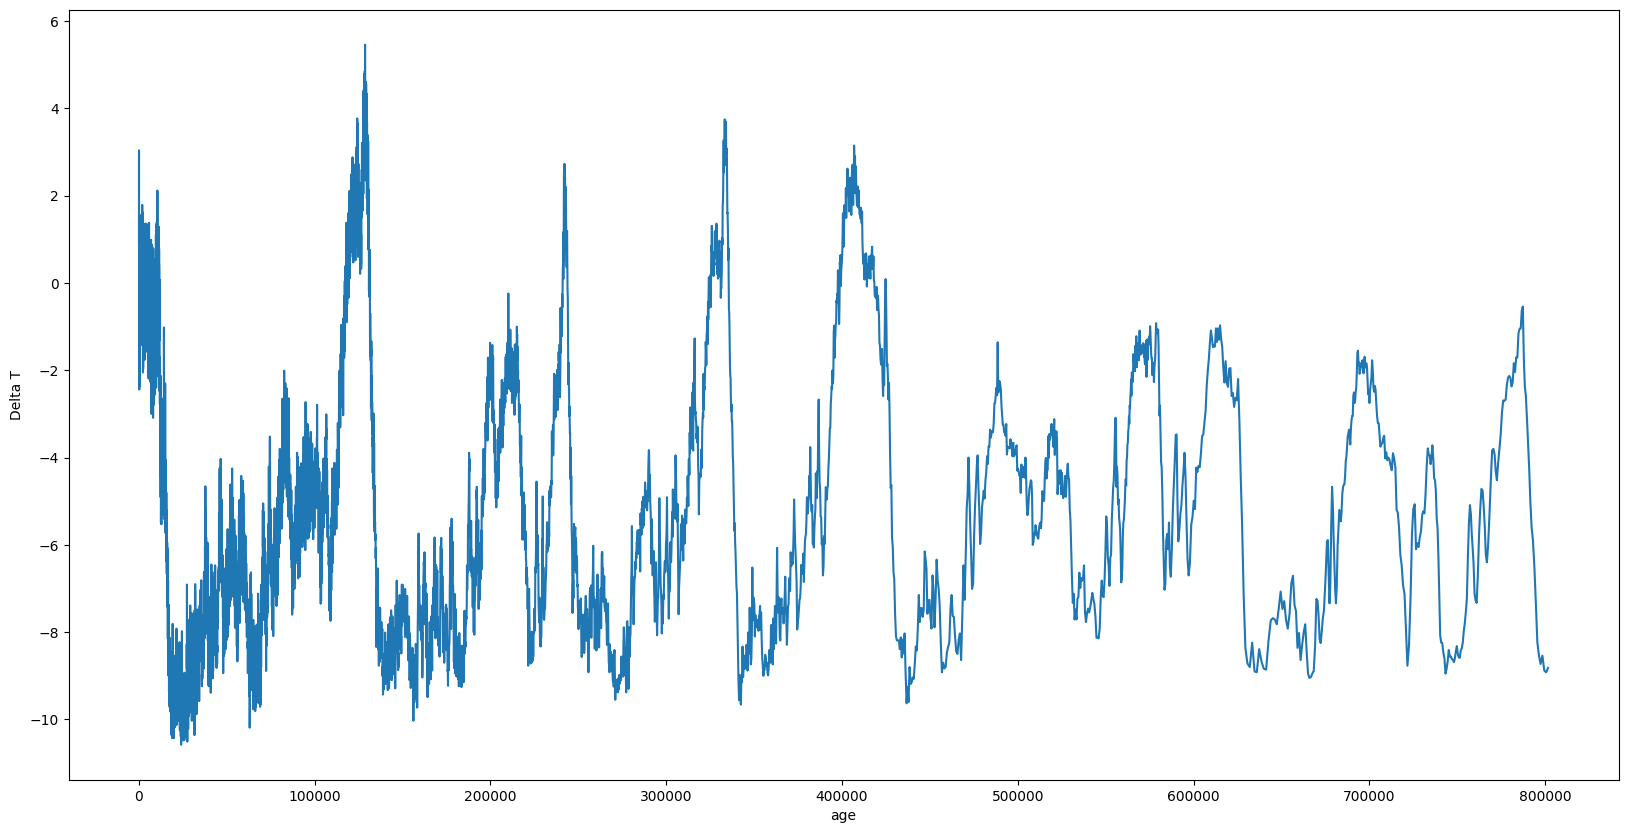

In [4]:
age = ice_data[2]
T = ice_data[4]
plt.plot(age,T)
plt.xlabel('age')
plt.ylabel('Delta T')
plt.show()

In [5]:
def model(theta,age=age):
    a1,a2,a3,p1,p2,p3,T0 = theta
    return a1*np.sin(2*np.pi*age/p1) + a2*np.sin(2*np.pi*age/p2) + a3*np.sin(2*np.pi*age/p3) + T0

In [6]:
def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model(theta, x))/yerr) ** 2)

In [14]:
def lnprior(theta):
    a1, a2, a3, p1, p2, p3, T0 = theta
    if 0.0 < a1 < 5.0 and 0.0 < a2 < 5.0 and 0.0 < a3 < 5.0 and 10000. < p1 < 200000 and 10000. < p2 < 200000 and 10000. < p3 < 200000 and -10.0 < T0 < 0:
        return 0.0
    return -np.inf

In [8]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [11]:
Terr = 0.05*np.mean(T)
data = (age, T,Terr)
nwalkers = 128
niter = 500
initial = np.array([1.0, 1.0, 1.0, 26000., 41000.,100000.,-4.5])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]



In [12]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

In [15]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...
Running production...


In [16]:
def plotter(sampler,age=age,T=T):
    plt.ion()
    plt.plot(age,T,label='Change in T')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(age, model(theta, age), color="r", alpha=0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('Years ago')
    plt.ylabel(r'$\Delta$ T (degrees)')
    plt.legend()
    plt.show()

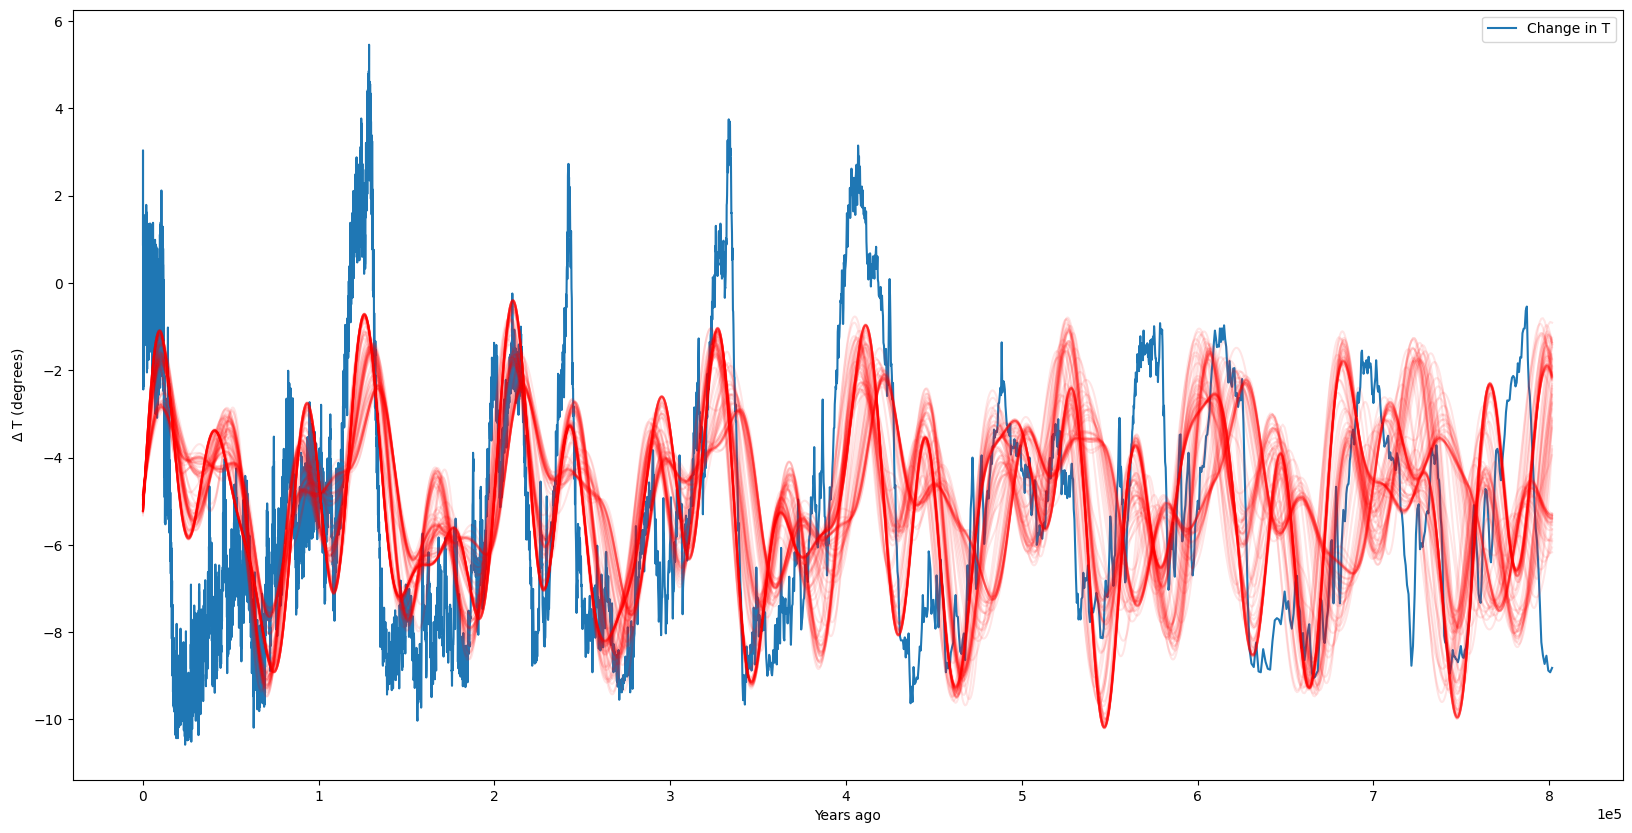

In [17]:
plotter(sampler)

In [18]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]



array([ 1.20454420e+00,  2.03425234e+00,  1.82381210e+00,  2.91373808e+04,
        3.97663776e+04,  9.60140610e+04, -5.24241220e+00])

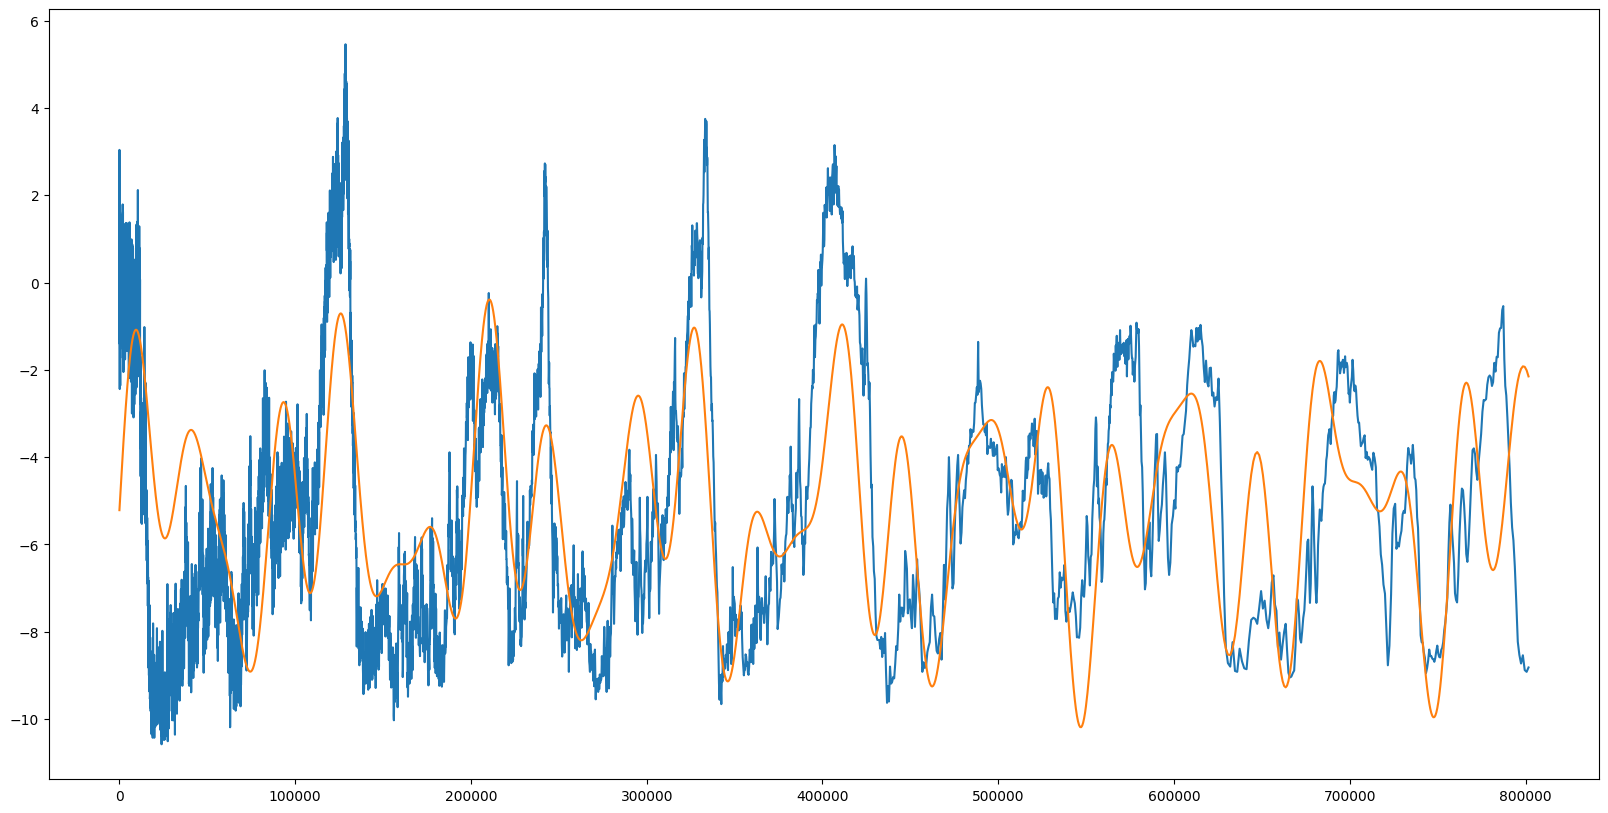

In [20]:
samples = sampler.flatchain

theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model(theta_max)
plt.plot(age,T,label='Change in T')
plt.plot(age,best_fit_model,label='Highest Likelihood Model')
plt.show()


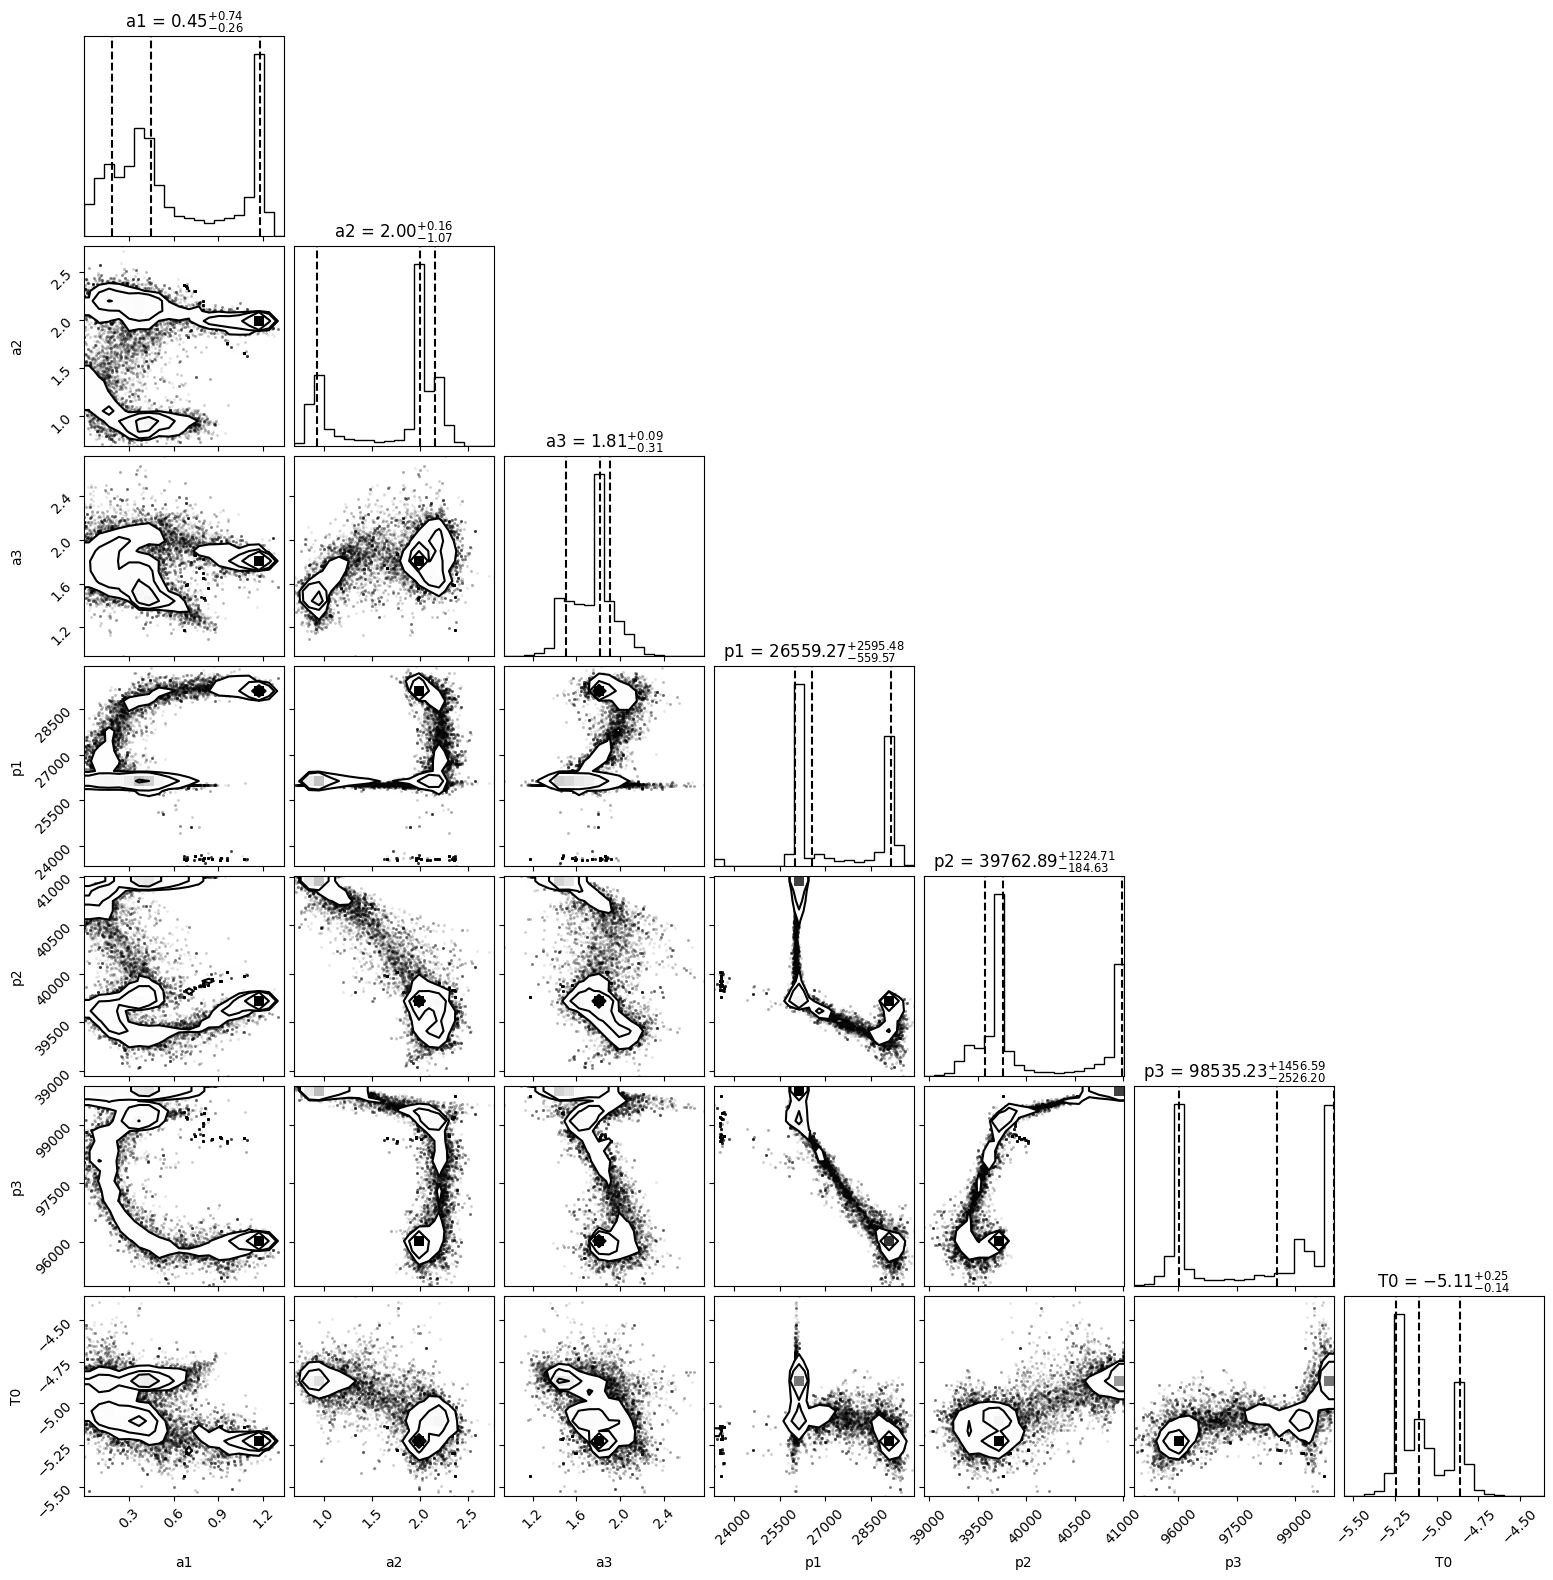

In [21]:
labels = ['a1','a2','a3','p1','p2','p3','T0']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

In [23]:
Terr = 0.05*np.mean(T)
data = (age, T,Terr)
nwalkers = 240
niter = 1024
initial = np.array([1.0, 1.0, 1.0, 26000., 41000.,100000.,-4.5])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]
new_sampler, newpos, newprob, newstate = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...
Running production...


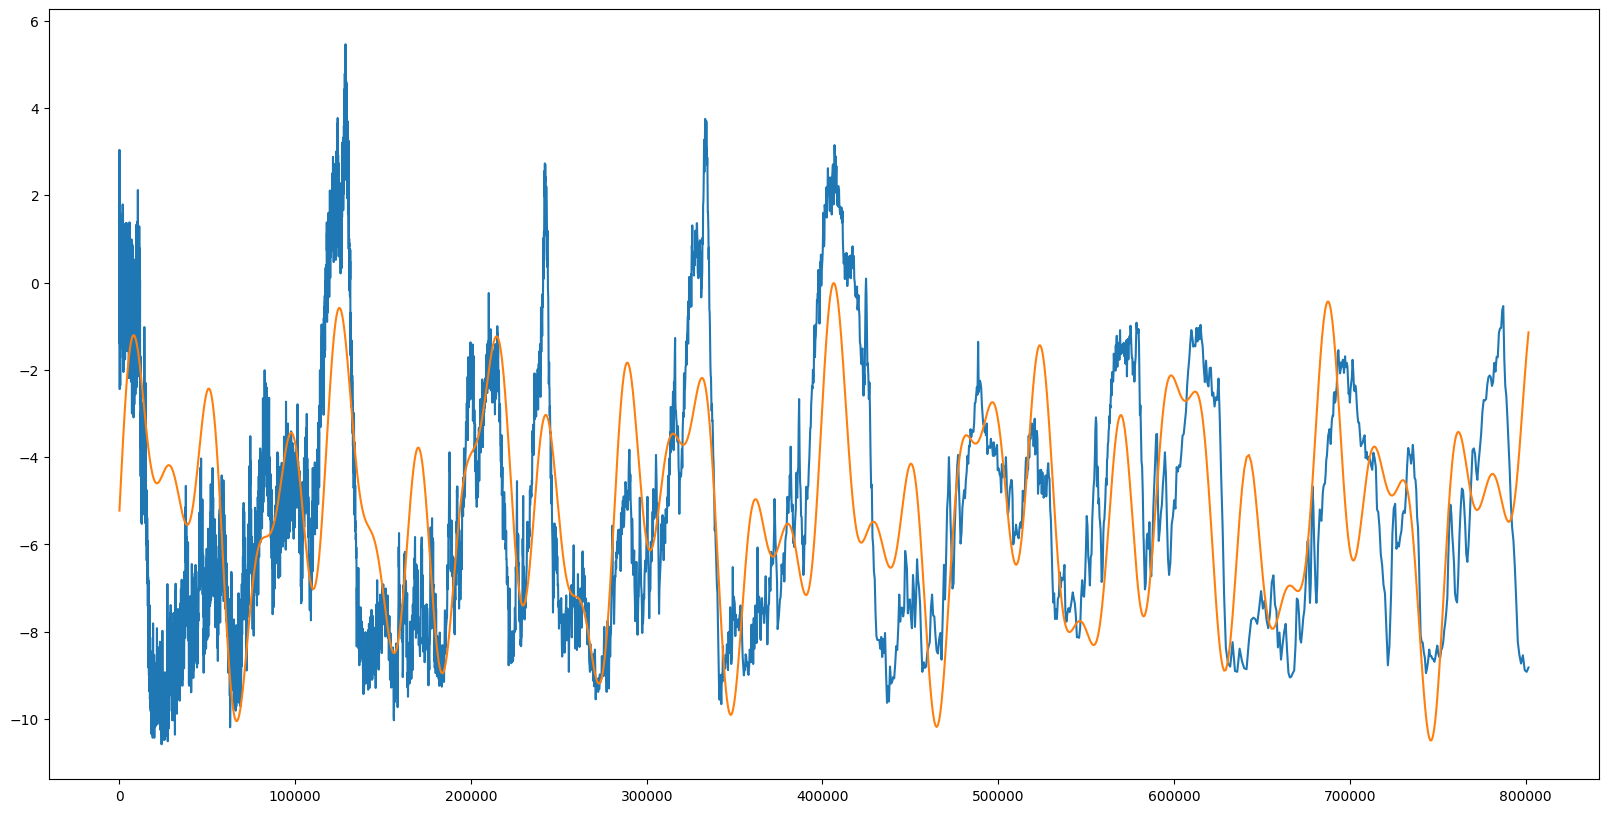

In [24]:
new_samples =  new_sampler.flatchain

new_theta_max  = new_samples[np.argmax(new_sampler.flatlnprobability)]
new_best_fit_model = model(new_theta_max)
plt.plot(age,T,label='Change in T')
plt.plot(age,new_best_fit_model,label='Highest Likelihood Model')
plt.show()


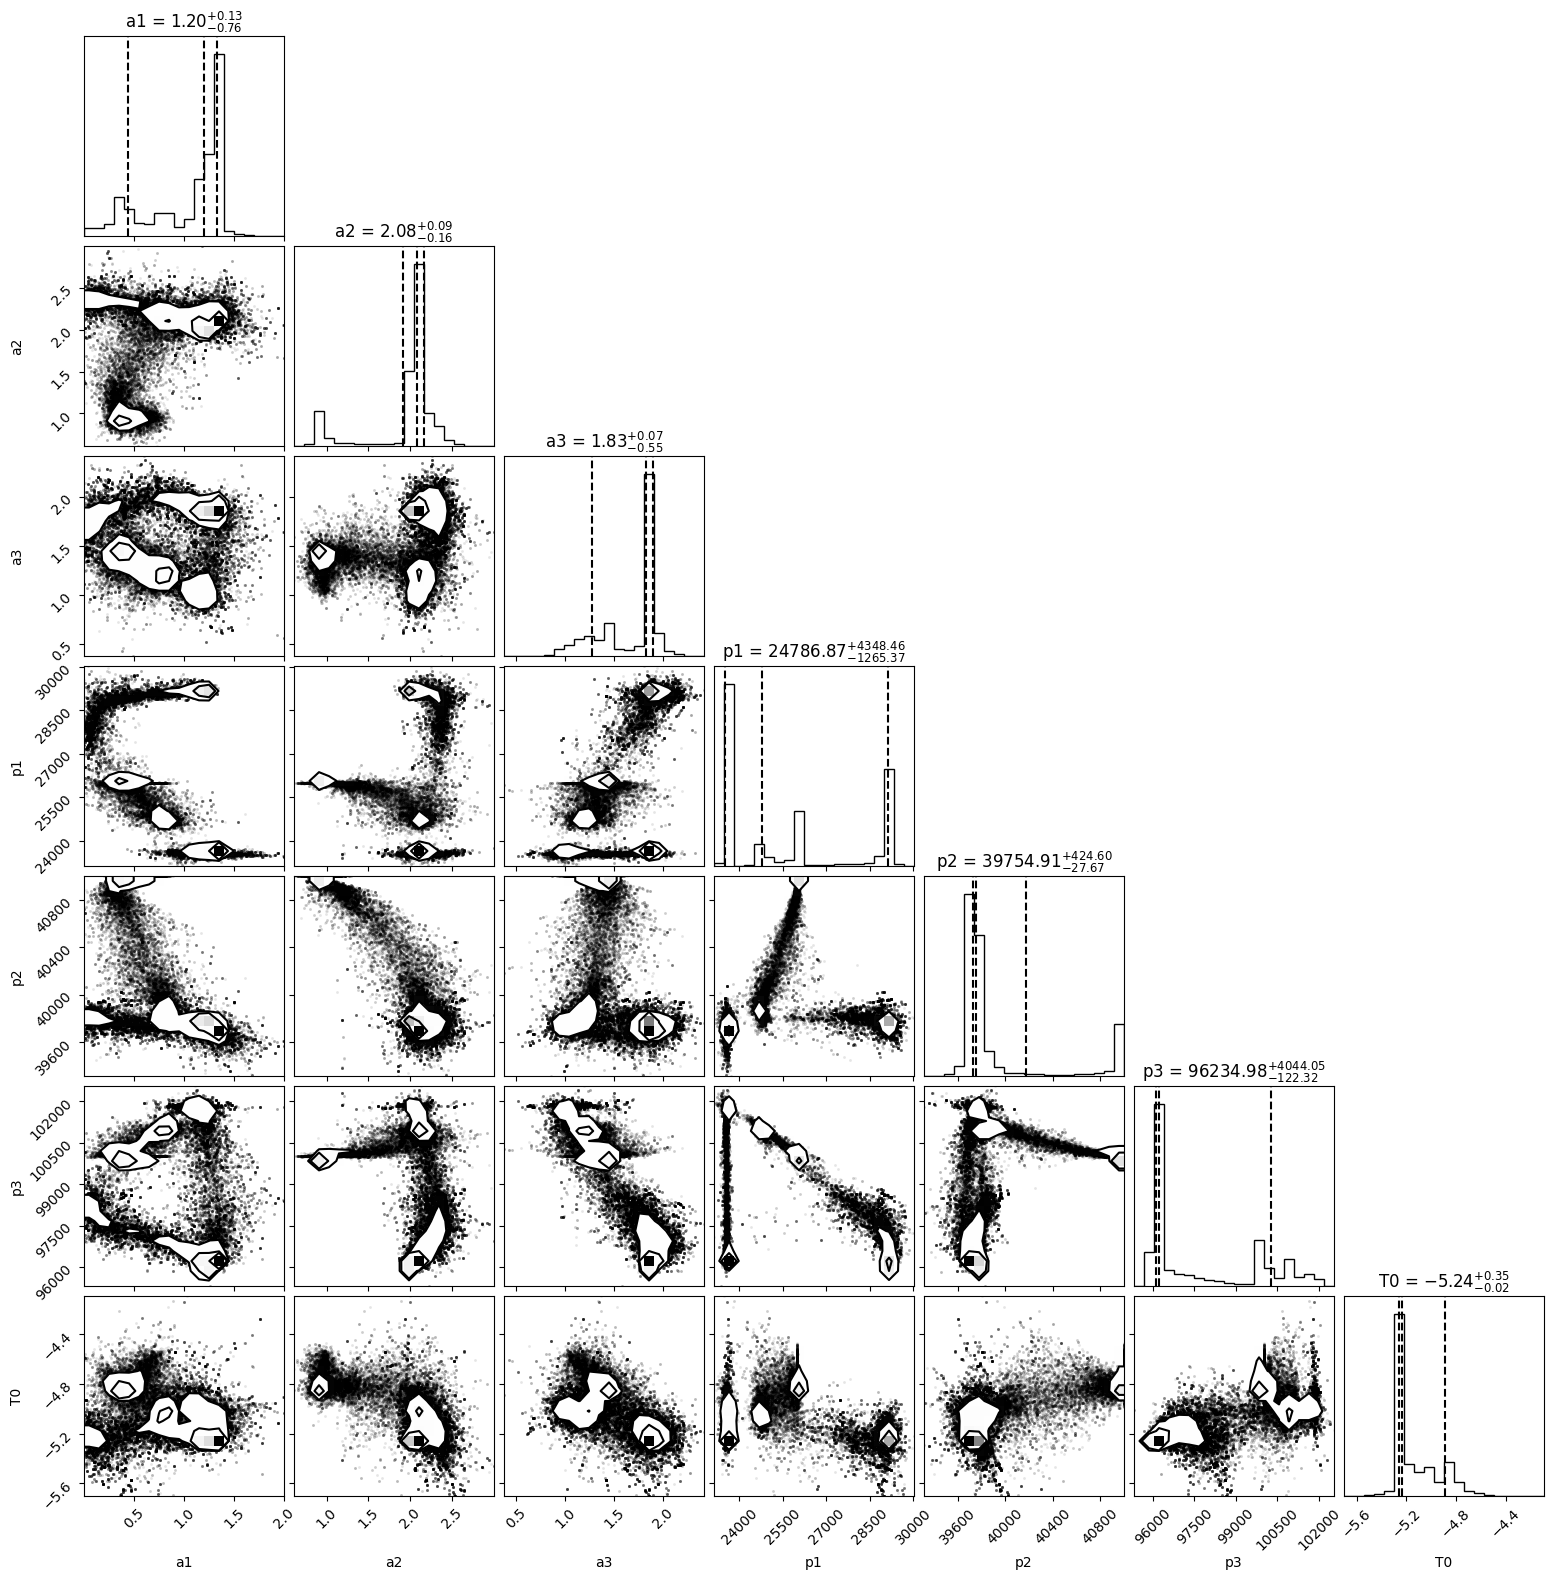

In [25]:
labels = ['a1','a2','a3','p1','p2','p3','T0']
fig = corner.corner(new_samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

In [26]:
def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = model(i)
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(100,new_samples)

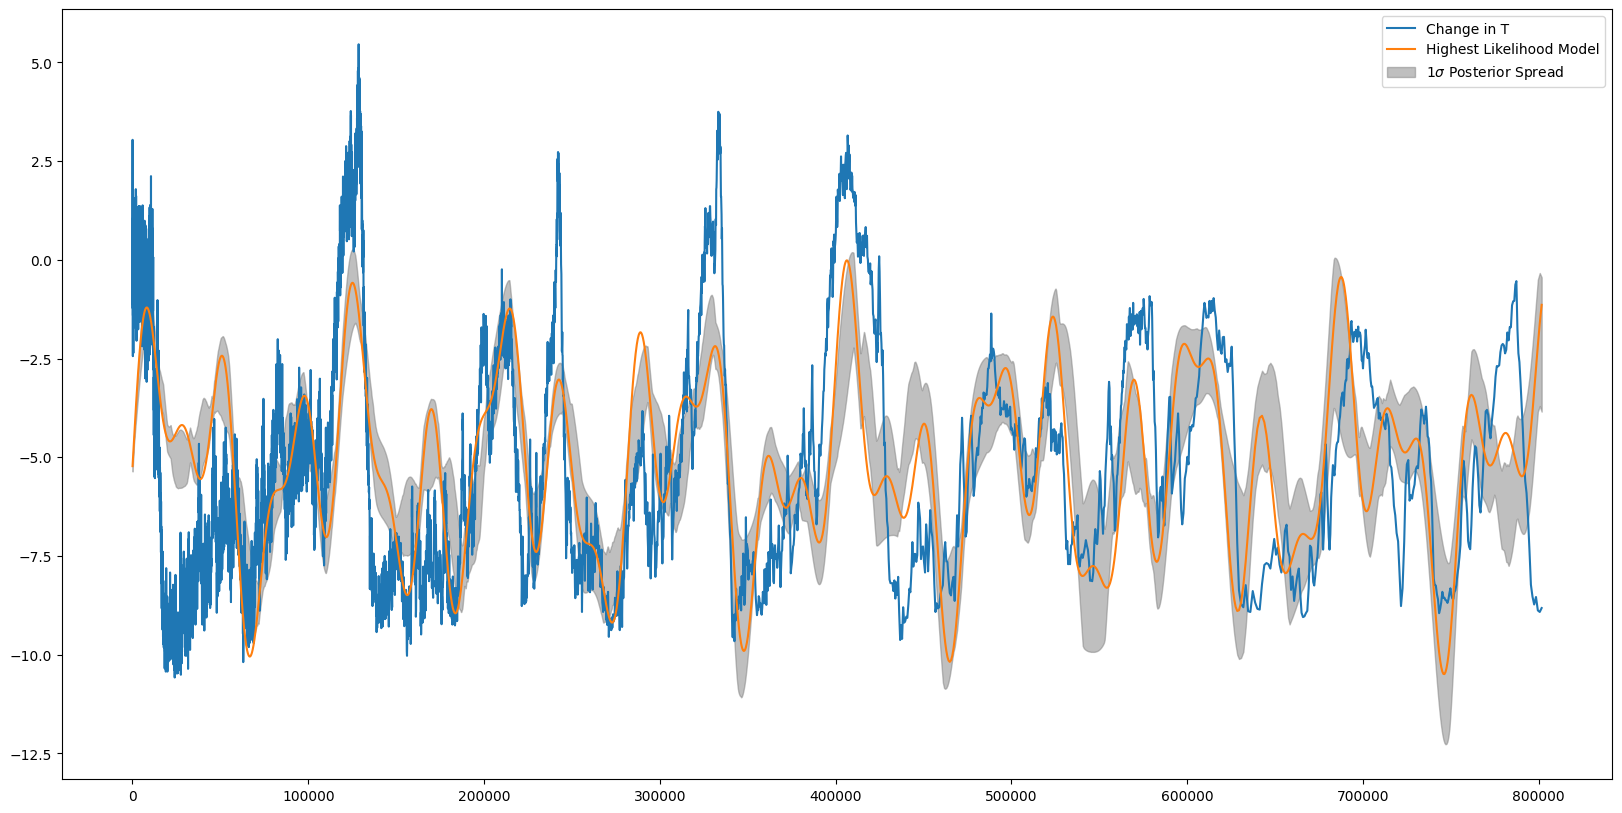

In [27]:
plt.plot(age,T,label='Change in T')
plt.plot(age,new_best_fit_model,label='Highest Likelihood Model')
plt.fill_between(age,med_model-spread,med_model+spread,color='grey',alpha=0.5,label=r'$1\sigma$ Posterior Spread')
plt.legend()